In [24]:
import random
from pathlib import Path
import re
from typing import List, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torchtext
import torchtext.vocab
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")
torchtext.disable_torchtext_deprecation_warning()
warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

filename = 'fake_and_real_news_dataset.csv'
datapath = Path.cwd().parent / 'data' / filename
sentences = pd.read_csv(str(datapath))

"""
generate vocabulary
"""

sentences = sentences["title"]
sentences = sentences.dropna()
sentences = sentences.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
sentences = sentences.apply(lambda x: re.sub(r'\b[b-hj-z]\b', ' ', x)) # floating single letters except 'a', 'i'

tokenizer = get_tokenizer('basic_english')
tokenized_sentences = [tokenizer(s) for s in sentences]

features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_sentences,
    min_freq=2, # minimum frequency of a word to be included in the vocabulary
    specials=['<pad>', '<oov>'], # pad = padding, oov = out of vocabulary
    special_first=True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_sentences,
    min_freq=2
)
print(f"{len(features_vocab)=}, {len(target_vocab)=}, {features_vocab['<pad>']=}, {features_vocab['<oov>']=}")

"""
encode sentences to ngrams of vocabulary indices
"""

def get_ngrams(tokenized_sentence: List[str]) -> List[List[str]]:
    # example: "hello beautiful world" -> ["hello", "hello beautiful", "hello beautiful world"]
    list_ngrams = []
    for i in range(1, len(tokenized_sentence)):
        ngram_sequence = tokenized_sentence[:i+1]
        list_ngrams.append(ngram_sequence)
    return list_ngrams

def insert_oovs(ngram: List[str]) -> List[str]:
    # replace 10% of tokens with <oov> token to simulate the presence of out-of-vocabulary words    
    for idx, _ in enumerate(ngram[:-1]):
        if random.uniform(0, 1) < 0.1:
            ngram[idx] = '<oov>'
    return ngram

def encode_to_vocab_idx(tokenized_sentence: List[str]) -> Optional[List[int]]:
    # encode by replacing each token with its index in the vocabulary
    tokens_list = []
    if tokenized_sentence[-1] in target_vocab.get_itos(): # get_itos() = get index to string
        for token in tokenized_sentence[:-1]:
            num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>'] # features from features_vocab
            tokens_list.append(num_token)
        num_token = target_vocab[tokenized_sentence[-1]] # target (last token) from target_vocab
        tokens_list.append(num_token)
        return tokens_list
    
    # target token is not in the vocabulary
    return None


ngrams_list = []
for tokenized_sentence in tokenized_sentences:
    ngrams_list.extend(get_ngrams(tokenized_sentence))

ngrams_list_oov = []
for ngram in ngrams_list:
    ngrams_list_oov.append(insert_oovs(ngram))

input_sequences = [encode_to_vocab_idx(sequence) for sequence in ngrams_list_oov if encode_to_vocab_idx(sequence)]


X = [sequence[:-1] for sequence in input_sequences] # type: ignore
y = [sequence[-1] for sequence in input_sequences] # type: ignore


longest_sequence_feature = max(len(sequence) for sequence in X)
padded_X = [F.pad(torch.tensor(sequence), (longest_sequence_feature - len(sequence), 0), value=0) for sequence in X]

longest_sequence_feature, padded_X[0], X[0], len(padded_X[0])

len(features_vocab)=3917, len(target_vocab)=3915, features_vocab['<pad>']=0, features_vocab['<oov>']=1


(40,
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9]),
 [9],
 40)

In [25]:
padded_X = torch.stack(padded_X)
y = torch.tensor(y)

y_one_hot = one_hot(y, num_classes=len(target_vocab))

data = TensorDataset(padded_X, y_one_hot)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 32
train_data, test_data = random_split(data, [train_size, test_size])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


class My_LSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_LSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True) 
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out[:, -1, :])
        return output


embedding_dim = longest_sequence_feature
hidden_dim = 200
epochs = 50
model = My_LSTM(len(features_vocab), len(target_vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)


def calculate_topk_accuracy(model, data_loader, k=3):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            output = model(batch_x)

            # Get top-k predictions
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k predictions
            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy


all_accuracies = []
all_losses = []
for epoch in tqdm(range(epochs)):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()
            
    if epoch % 5 == 0:
        accuracy = calculate_topk_accuracy(model, train_loader)
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Train K-Accuracy: {accuracy * 100:.2f}%')
        all_accuracies.append(accuracy)
        all_losses.append(loss.item())


  2%|▏         | 1/50 [00:08<07:15,  8.89s/it]

Epoch 0/50, Loss: 7.5372, Train K-Accuracy: 10.45%


 12%|█▏        | 6/50 [00:38<04:47,  6.54s/it]

Epoch 5/50, Loss: 6.1990, Train K-Accuracy: 24.56%


 22%|██▏       | 11/50 [01:08<04:08,  6.37s/it]

Epoch 10/50, Loss: 4.1101, Train K-Accuracy: 48.48%


 32%|███▏      | 16/50 [01:37<03:39,  6.45s/it]

Epoch 15/50, Loss: 3.5579, Train K-Accuracy: 67.97%


 42%|████▏     | 21/50 [02:08<03:12,  6.62s/it]

Epoch 20/50, Loss: 3.5474, Train K-Accuracy: 78.38%


 52%|█████▏    | 26/50 [02:40<02:39,  6.66s/it]

Epoch 25/50, Loss: 3.6864, Train K-Accuracy: 84.14%


 62%|██████▏   | 31/50 [03:12<02:11,  6.90s/it]

Epoch 30/50, Loss: 2.1159, Train K-Accuracy: 87.36%


 72%|███████▏  | 36/50 [03:47<01:40,  7.18s/it]

Epoch 35/50, Loss: 1.6780, Train K-Accuracy: 89.20%


 82%|████████▏ | 41/50 [04:17<01:00,  6.69s/it]

Epoch 40/50, Loss: 1.4434, Train K-Accuracy: 90.35%


 92%|█████████▏| 46/50 [04:48<00:26,  6.62s/it]

Epoch 45/50, Loss: 1.9928, Train K-Accuracy: 91.08%


100%|██████████| 50/50 [05:11<00:00,  6.24s/it]


# benchmark

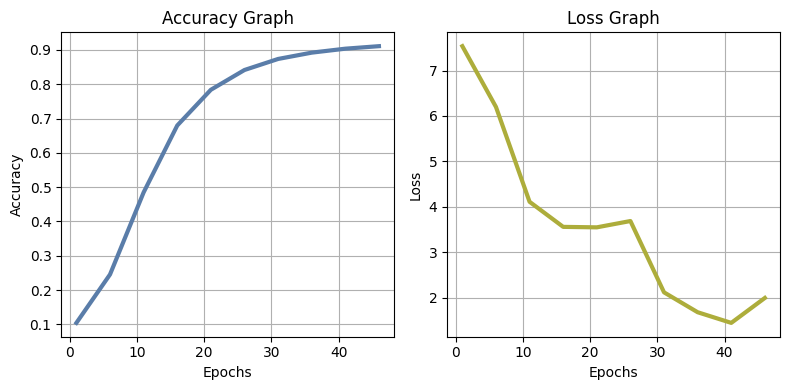

In [26]:
epoch_list = [i for i in range(1,epochs,5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) 

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)
 
axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [27]:
accuracy = calculate_topk_accuracy(model, test_loader)
print(f'Test K-Accuracy: {accuracy * 100:.2f}%')

Test K-Accuracy: 16.63%


In [28]:
def text_to_numerical_sequence_test(tokenized_text):
    tokens_list = []
    for token in tokenized_text:
        num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
        tokens_list.append(num_token)
    return tokens_list

def use_model(input_list):
    model.eval()
    output_list = []
    for data in input_list:
        sentence = data[0]
        num_words = data[1]
        for _ in range(num_words):
            output_of_model = []
            tokenized_input_test = tokenizer(sentence)
            tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
            padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test), (longest_sequence_feature - len(tokenized_sequence_input_test)-1, 0), value=0)
            output_test_walking = torch.argmax(model(padded_tokenized_sequence_input_test.unsqueeze(0)))
            sentence = sentence + ' ' + target_vocab.lookup_token(output_test_walking.item()) # type: ignore
        output_list.append(sentence)
    return output_list

input_test = [['stand', 5], ['deep learning is', 5], ['data cleaning', 4], ['6 ways', 4], ['you did a', 2]]
outputs_model = use_model(input_test)
outputs_model


['stand of the day dennis kucinich',
 'deep learning is in the most important message',
 'data cleaning hillary clinton and the',
 '6 ways to fix the polarization',
 'you did a get to']